<a href="https://colab.research.google.com/github/reichlab/pylssm/blob/master/SARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/tensorflow/probability.git
import sys
sys.path.append('/content/probability')

fatal: destination path 'probability' already exists and is not an empty directory.


In [3]:
cd /content/probability/tensorflow_probability

/content/probability/tensorflow_probability


In [8]:
import numpy as np
import pandas as pd
import tensorflow_probability as tfp
from tensorflow_probability import sts
%matplotlib inline
import matplotlib as mpl
from matplotlib import pylab as plt

In [5]:
# Copyright 2018 The TensorFlow Probability Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ============================================================================
"""Autoregressive model."""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# Dependency imports
import tensorflow.compat.v2 as tf

from tensorflow_probability.python import bijectors as tfb
from tensorflow_probability.python import distributions as tfd
from tensorflow_probability.python.internal import distribution_util as dist_util
from tensorflow_probability.python.internal import dtype_util

from tensorflow_probability.python.sts.internal import util as sts_util
from tensorflow_probability.python.sts.structural_time_series import Parameter
from tensorflow_probability.python.sts.structural_time_series import StructuralTimeSeries


class SARIMAStateSpaceModel(tfd.LinearGaussianStateSpaceModel):
  """State space model for an ARMA process.
  A state space model (SSM) posits a set of latent (unobserved) variables that
  evolve over time with dynamics specified by a probabilistic transition model
  `p(z[t+1] | z[t])`. At each timestep, we observe a value sampled from an
  observation model conditioned on the current state, `p(x[t] | z[t])`. The
  special case where both the transition and observation models are Gaussians
  with mean specified as a linear function of the inputs, is known as a linear
  Gaussian state space model and supports tractable exact probabilistic
  calculations; see `tfp.distributions.LinearGaussianStateSpaceModel` for
  details.
  In an autoregressive process, the expected level at each timestep is a linear
  function of previous levels, with added Gaussian noise:
  ```python
  level[t+1] = (sum(coefficients * levels[t:t-order:-1]) +
                Normal(0., level_scale))
  ```
  The process is characterized by a vector `coefficients` whose size determines
  the order of the process (how many previous values it looks at), and by
  `level_scale`, the standard deviation of the noise added at each step.
  This is formulated as a state space model by letting the latent state encode
  the most recent values; see 'Mathematical Details' below.
  The parameters `level_scale` and `observation_noise_scale` are each (a batch
  of) scalars, and `coefficients` is a (batch) vector of size `[order]`. The
  batch shape of this `Distribution` is the broadcast batch
  shape of these parameters and of the `initial_state_prior`.
  #### Mathematical Details
  The autoregressive model implements a
  `tfp.distributions.LinearGaussianStateSpaceModel` with `latent_size = order`
  and `observation_size = 1`. The latent state vector encodes the recent history
  of the process, with the current value in the topmost dimension. At each
  timestep, the transition sums the previous values to produce the new expected
  value, shifts all other values down by a dimension, and adds noise to the
  current value. This is formally encoded by the transition model:
  ```
  transition_matrix = [ coefs[0], coefs[1], ..., coefs[order]
                        1.,       0 ,       ..., 0.
                        0.,       1.,       ..., 0.
                        ...
                        0.,       0.,  ...,  1.,  0.            ]
  transition_noise ~ N(loc=0., scale=diag([level_scale, 0., 0., ..., 0.]))
  ```
  The observation model simply extracts the current (topmost) value, and
  optionally adds independent noise at each step:
  ```
  observation_matrix = [[1., 0., ..., 0.]]
  observation_noise ~ N(loc=0, scale=observation_noise_scale)
  ```
  Models with `observation_noise_scale = 0.` are AR processes in the formal
  sense. Setting `observation_noise_scale` to a nonzero value corresponds to a
  latent AR process observed under an iid noise model.
  #### Examples
  A simple model definition:
  ```python
  ar_model = AutoregressiveStateSpaceModel(
      num_timesteps=50,
      coefficients=[0.8, -0.1],
      level_scale=0.5,
      initial_state_prior=tfd.MultivariateNormalDiag(
        scale_diag=[1., 1.]))
  y = ar_model.sample() # y has shape [50, 1]
  lp = ar_model.log_prob(y) # log_prob is scalar
  ```
  Passing additional parameter dimensions constructs a batch of models. The
  overall batch shape is the broadcast batch shape of the parameters:
  ```python
  ar_model = AutoregressiveStateSpaceModel(
      num_timesteps=50,
      coefficients=[0.8, -0.1],
      level_scale=tf.ones([10]),
      initial_state_prior=tfd.MultivariateNormalDiag(
        scale_diag=tf.ones([10, 10, 2])))
  y = ar_model.sample(5) # y has shape [5, 10, 10, 50, 1]
  lp = ar_model.log_prob(y) # has shape [5, 10, 10]
  ```
  """

  def __init__(self,
               num_timesteps,
               phi,
               phi_seasonal,
               theta,
               theta_seasonal,
               p_ar,
               P_ar,
               q_ma,
               Q_ma,
               r,
               ts_frequency,
               # variance of w_t
               level_scale,
               initial_state_prior,
               # variance of uncorrelated white noise in obs eq.
               observation_noise_scale=0.,
               initial_step=0,
               validate_args=False,
               name=None):
    """Build a state space model implementing an autoregressive process.
    Args:
      num_timesteps: Scalar `int` `Tensor` number of timesteps to model
        with this distribution.
      coefficients: `float` `Tensor` of shape `concat(batch_shape, [order])`
        defining  the autoregressive coefficients. The coefficients are defined
        backwards in time: `coefficients[0] * level[t] + coefficients[1] *
        level[t-1] + ... + coefficients[order-1] * level[t-order+1]`.
      level_scale: Scalar (any additional dimensions are treated as batch
        dimensions) `float` `Tensor` indicating the standard deviation of the
        transition noise at each step.
      initial_state_prior: instance of `tfd.MultivariateNormal`
        representing the prior distribution on latent states.  Must have
        event shape `[order]`.
      observation_noise_scale: Scalar (any additional dimensions are
        treated as batch dimensions) `float` `Tensor` indicating the standard
        deviation of the observation noise.
        Default value: 0.
      initial_step: Optional scalar `int` `Tensor` specifying the starting
        timestep.
        Default value: 0.
      validate_args: Python `bool`. Whether to validate input
        with asserts. If `validate_args` is `False`, and the inputs are
        invalid, correct behavior is not guaranteed.
        Default value: `False`.
      name: Python `str` name prefixed to ops created by this class.
        Default value: "AutoregressiveStateSpaceModel".
    """
    with tf.name_scope(name or 'SARIMAStateSpaceModel') as name:

      # The initial state prior determines the dtype of sampled values.
      # Other model parameters must have the same dtype.
      dtype = initial_state_prior.dtype

      phi = tf.convert_to_tensor(
          value=phi, name='phi', dtype=dtype)
      phi_seasonal = tf.convert_to_tensor(
          value=phi_seasonal, name='phi_seasonal', dtype=dtype)
      theta = tf.convert_to_tensor(
          value=theta, name='theta', dtype=dtype)
      theta_seasonal = tf.convert_to_tensor(
          value=theta_seasonal, name='theta_seasonal', dtype=dtype)
      level_scale = tf.convert_to_tensor(
          value=level_scale, name='level_scale', dtype=dtype)
      observation_noise_scale = tf.convert_to_tensor(
          value=observation_noise_scale,
          name='observation_noise_scale', dtype=dtype)

      #p_ar = tf.compat.dimension_value(phi.shape[-1])
      if p_ar is None:
        raise ValueError('Autoregressive coefficients must have static shape.')
      if P_ar is None:
        raise ValueError('Autoregressive coefficients must have static shape.')
      
      #q_ma = tf.compat.dimension_value(theta.shape[-1])
      if q_ma is None:
        raise ValueError('Moving Average coefficients must have static shape.')
      if Q_ma is None:
        raise ValueError('Moving Average coefficients must have static shape.')

      #r = max(p_ar, q_ma+1)

      self._p_ar = p_ar
      self._P_ar = P_ar
      self._q_ma = q_ma
      self._Q_ma = Q_ma
      self._r = r
      self._ts_frequency = ts_frequency
      self._phi = phi
      self._phi_seasonal = phi_seasonal
      self._theta = theta
      self._theta_seasonal = theta_seasonal
      self._level_scale = level_scale

      super(SARIMAStateSpaceModel, self).__init__(
          num_timesteps=num_timesteps,
          transition_matrix=make_ar_transition_matrix(phi, phi_seasonal, self.r, self.ts_frequency,
                                                      self.p_ar, self.P_ar),
          transition_noise=tfd.MultivariateNormalDiag(
              scale_diag=tf.stack([level_scale] +
                                  [tf.zeros_like(level_scale)] * (
                                      self.r - 1), axis=-1)),
          observation_matrix= make_ma_observation_matrix (theta, theta_seasonal, self.r,self.ts_frequency,
                                                          self.q_ma, self.Q_ma),
          observation_noise=tfd.MultivariateNormalDiag(
              scale_diag=observation_noise_scale[..., tf.newaxis]),
          initial_state_prior=initial_state_prior,
          initial_step=initial_step,
          validate_args=validate_args,
          name=name)

  @property
  def q_ma(self):
    return self._q_ma

  @property
  def Q_ma(self):
    return self._Q_ma

  @property
  def p_ar(self):
    return self._p_ar

  @property
  def P_ar(self):
    return self._P_ar

  @property
  def r(self):
    return self._r

  @property
  def ts_frequency(self):
    return self._ts_frequency

  @property
  def phi(self):
    return self._phi

  @property
  def phi_seasonal(self):
    return self._phi_seasonal

  @property
  def theta(self):
    return self._theta

  @property
  def theta_seasonal(self):
    return self._theta_seasonal

  @property
  def level_scale(self):
    return self._level_scale


# similar to T 
# 0 -> order -1
def make_ar_transition_matrix(phi, phi_seasonal, r, ts_frequency, p_ar, P_ar):
  """Build transition matrix for an autoregressive StateSpaceModel.
  When applied to a vector of previous values, this matrix computes
  the expected new value (summing the previous states according to the
  autoregressive coefficients) in the top dimension of the state space,
  and moves all previous values down by one dimension, 'forgetting' the
  final (least recent) value. That is, it looks like this:
  ```
  ar_matrix = [ coefs[0], coefs[1], ..., coefs[p_ar], ..., 0, 0
                1.,       0 ,                         ..., 0, 0.
                0.,       1.,                         ..., 0, 0.
                ...
                0.,       0.,  ...,                        1, 0.]
  ```
  Args:
    coefficients: float `Tensor` of shape `concat([batch_shape, [order]])`.
  Returns:
    ar_matrix: float `Tensor` with shape `concat([batch_shape,
    [order, order]])`.
  """
  
  coef_shape = dist_util.prefer_static_shape(phi)
  # batch_shape = 0
  batch_shape = coef_shape[:-1]

  dummy_phi = tf.zeros(tf.concat([batch_shape, (1,r)], axis=0), dtype=phi.dtype)

  shape = dummy_phi.get_shape() 

  if p_ar > 0:
    indices = tf.constant([[0,i] for i in range(p_ar)], dtype = 'int64')
    coefs = tf.sparse.SparseTensor(indices = indices, values = phi, dense_shape = shape)
    print(tf.sparse.to_dense(coefs))
    dummy_phi = dummy_phi + tf.sparse.to_dense(coefs)
    print(dummy_phi)
  
  if P_ar > 0:
    indices = tf.constant([[0,(i+1) * ts_frequency -1] for i in range(P_ar)],dtype = 'int64')
    coefs = tf.sparse.SparseTensor(indices = indices, values = phi_seasonal, dense_shape = shape)
    print(tf.sparse.to_dense(coefs))
    dummy_phi = dummy_phi + tf.sparse.to_dense(coefs)
    print(dummy_phi)

  if p_ar > 0 and P_ar > 0:
    # indices need to be sorted
    indices = tf.constant([[0,i+ (j+1) * ts_frequency] for j in range(P_ar) for i in range(p_ar)], dtype = 'int64')
    values = [(-1)* phi[i] * phi_seasonal[j] for i in range(p_ar) for j in range(P_ar)] 
    coefs = tf.sparse.SparseTensor(indices = indices, values = values, dense_shape = shape)
    print(tf.sparse.to_dense(coefs))
    dummy_phi = dummy_phi + tf.sparse.to_dense(coefs)
    print(dummy_phi)


  remaining_rows = tf.concat([
      tf.eye(r - 1, dtype=phi.dtype, batch_shape=batch_shape),
      tf.zeros(tf.concat([batch_shape, (r - 1, 1)], axis=0),
               dtype=phi.dtype)
  ], axis=-1)

  ar_matrix = tf.concat([dummy_phi, remaining_rows], axis=-2)


  print("transition matrix ")
  print(ar_matrix)
  return ar_matrix

# 1--> order -1 
def make_ma_observation_matrix(theta, theta_seasonal, r, ts_frequency, q_ma, Q_ma):

  coef_shape = dist_util.prefer_static_shape(theta)
  # batch_shape = 0
  batch_shape = coef_shape[:-1]

  dummy_theta = tf.zeros(tf.concat([batch_shape, (1,r-1)], axis=0), dtype=theta.dtype)

  shape = dummy_theta.get_shape() 

  if q_ma > 0:
    indices = tf.constant([[0,i] for i in range(q_ma)], dtype = 'int64')
    coefs = tf.sparse.SparseTensor(indices = indices, values = theta, dense_shape = shape)
    print(tf.sparse.to_dense(coefs))
    dummy_theta = dummy_theta + tf.sparse.to_dense(coefs)
    print(dummy_theta)
  
  if Q_ma > 0:
    indices = tf.constant([[0,(i+1) * ts_frequency -1] for i in range(Q_ma)],dtype = 'int64')
    coefs = tf.sparse.SparseTensor(indices = indices, values = theta_seasonal, dense_shape = shape)
    print(tf.sparse.to_dense(coefs))
    dummy_theta = dummy_theta + tf.sparse.to_dense(coefs)
    print(dummy_theta)

  if q_ma > 0 and Q_ma > 0:
    # indices need to be sorted
    indices = tf.constant([[0,i+ (j+1) * ts_frequency] for j in range(Q_ma) for i in range(q_ma)], dtype = 'int64')
    values = [(-1)* theta[i] * theta_seasonal[j] for i in range(q_ma) for j in range(Q_ma)] 
    coefs = tf.sparse.SparseTensor(indices = indices, values = values, dense_shape = shape)
    print(tf.sparse.to_dense(coefs))
    dummy_theta = dummy_theta + tf.sparse.to_dense(coefs)
    print(dummy_theta)


  # make a row vector
  ma_matrix = tf.concat([tf.ones(
      tf.concat([batch_shape, (1,1)], axis=0), dtype=theta.dtype), 
      dummy_theta], axis=-1)
  
  print ("observation matrix")
  print(ma_matrix)
  return ma_matrix


class SARIMA(StructuralTimeSeries):
  """Formal representation of an autoregressive model.
  An autoregressive (AR) model posits a latent `level` whose value at each step
  is a noisy linear combination of previous steps:
  ```python
  level[t+1] = (sum(coefficients * levels[t:t-order:-1]) +
                Normal(0., level_scale))
  ```
  The latent state is `levels[t:t-order:-1]`. We observe a noisy realization of
  the current level: `f[t] = level[t] + Normal(0., observation_noise_scale)` at
  each timestep.
  If `coefficients=[1.]`, the AR process is a simple random walk, equivalent to
  a `LocalLevel` model. However, a random walk's variance increases with time,
  while many AR processes (in particular, any first-order process with
  `abs(coefficient) < 1`) are *stationary*, i.e., they maintain a constant
  variance over time. This makes AR processes useful models of uncertainty.
  See the [Wikipedia article](
  https://en.wikipedia.org/wiki/Autoregressive_model#Definition) for details on
  stationarity and other mathematical properties of autoregressive processes.
  """

  def __init__(self,
               p_ar,
               P_ar,
               q_ma,
               Q_ma,
               ts_frequency,
               r,
               phi_prior=None,
               phi_seasonal_prior = None,
               theta_prior=None,
               theta_seasonal_prior = None,
               level_scale_prior=None,
               initial_state_prior=None,
               coefficient_constraining_bijector=None,
               observed_time_series=None,
               name=None):
    """Specify an autoregressive model.
    Args:
      order: scalar Python positive `int` specifying the number of past
        timesteps to regress on.
      coefficients_prior: optional `tfd.Distribution` instance specifying a
        prior on the `coefficients` parameter. If `None`, a default standard
        normal (`tfd.MultivariateNormalDiag(scale_diag=tf.ones([order]))`) prior
        is used.
        Default value: `None`.
      level_scale_prior: optional `tfd.Distribution` instance specifying a prior
        on the `level_scale` parameter. If `None`, a heuristic default prior is
        constructed based on the provided `observed_time_series`.
        Default value: `None`.
      initial_state_prior: optional `tfd.Distribution` instance specifying a
        prior on the initial state, corresponding to the values of the process
        at a set of size `order` of imagined timesteps before the initial step.
        If `None`, a heuristic default prior is constructed based on the
        provided `observed_time_series`.
        Default value: `None`.
      coefficient_constraining_bijector: optional `tfb.Bijector` instance
        representing a constraining mapping for the autoregressive coefficients.
        For example, `tfb.Tanh()` constrains the coefficients to lie in
        `(-1, 1)`, while `tfb.Softplus()` constrains them to be positive, and
        `tfb.Identity()` implies no constraint. If `None`, the default behavior
        constrains the coefficients to lie in `(-1, 1)` using a `Tanh` bijector.
        Default value: `None`.
      observed_time_series: optional `float` `Tensor` of shape
        `batch_shape + [T, 1]` (omitting the trailing unit dimension is also
        supported when `T > 1`), specifying an observed time series.
        Any priors not explicitly set will be given default values according to
        the scale of the observed time series (or batch of time series). May
        optionally be an instance of `tfp.sts.MaskedTimeSeries`, which includes
        a mask `Tensor` to specify timesteps with missing observations.
        Default value: `None`.
      name: the name of this model component.
        Default value: 'Autoregressive'.
    """
    with tf.name_scope(name or 'SARIMA') as name:
      masked_time_series = None
      if observed_time_series is not None:
        masked_time_series = (
            sts_util.canonicalize_observed_time_series_with_mask(
                observed_time_series))

      dtype = dtype_util.common_dtype(
          [(masked_time_series.time_series
            if masked_time_series is not None else None),
           phi_prior,
           phi_seasonal_prior,
           theta_prior,
           theta_seasonal_prior,
           level_scale_prior,
           initial_state_prior], dtype_hint=tf.float32)

      if observed_time_series is not None:
        _, observed_stddev, observed_initial = sts_util.empirical_statistics(
            masked_time_series)
      else:
        observed_stddev, observed_initial = (
            tf.convert_to_tensor(value=1., dtype=dtype),
            tf.convert_to_tensor(value=0., dtype=dtype))
      p_ar_batch_ones = tf.ones(tf.concat([
          tf.shape(observed_initial),  # Batch shape
          [p_ar]], axis=0), dtype=dtype)
      
      P_ar_batch_ones = tf.ones(tf.concat([
          tf.shape(observed_initial),  # Batch shape
          [P_ar]], axis=0), dtype=dtype)
      
      q_ma_batch_ones = tf.ones(tf.concat([
          tf.shape(observed_initial),  # Batch shape
          [q_ma]], axis=0), dtype=dtype)
      
      Q_ma_batch_ones = tf.ones(tf.concat([
          tf.shape(observed_initial),  # Batch shape
          [Q_ma]], axis=0), dtype=dtype)
      
      r_batch_ones = tf.ones(tf.concat([
          tf.shape(observed_initial),  # Batch shape
          [r]], axis=0), dtype=dtype)


      # Heuristic default priors. Overriding these may dramatically
      # change inference performance and results.
      if phi_prior is None:
        phi_prior = tfd.MultivariateNormalDiag(
            scale_diag=p_ar_batch_ones)
      if phi_seasonal_prior is None:
        phi_seasonal_prior = tfd.MultivariateNormalDiag(
            scale_diag=P_ar_batch_ones)
      if theta_prior is None:
        theta_prior = tfd.MultivariateNormalDiag(
            scale_diag=q_ma_batch_ones)
      if theta_seasonal_prior is None:
        theta_seasonal_prior = tfd.MultivariateNormalDiag(
            scale_diag=Q_ma_batch_ones)
      if level_scale_prior is None:
        level_scale_prior = tfd.LogNormal(
            loc=tf.math.log(0.05 *  observed_stddev), scale=3.)

      if (phi_prior.event_shape.is_fully_defined() and
          p_ar != phi_prior.event_shape[0]):
        raise ValueError("Phi Prior dimension {} doesn't match order {}.".format(
            phi_prior.event_shape[0], p_ar))
        
      if (phi_seasonal_prior.event_shape.is_fully_defined() and
          P_ar != phi_seasonal_prior.event_shape[0]):
        raise ValueError("Phi seasonal Prior dimension {} doesn't match order {}.".format(
            phi_seasonal_prior.event_shape[0], P_ar))
        
      if (theta_prior.event_shape.is_fully_defined() and
          q_ma != theta_prior.event_shape[0]):
        raise ValueError("Theta Prior dimension {} doesn't match order {}.".format(
            theta_prior.event_shape[0], q_ma))
        
      if (theta_seasonal_prior.event_shape.is_fully_defined() and
          Q_ma != theta_seasonal_prior.event_shape[0]):
        raise ValueError("Theta seasonal Prior dimension {} doesn't match order {}.".format(
            theta_seasonal_prior.event_shape[0], Q_ma))
        
      if ( r !=  max(p_ar+P_ar*ts_frequency, q_ma+Q_ma*ts_frequency+1)):
        raise ValueError("R value {} doesn't match {}.".format(
            r,  max(p_ar+P_ar*ts_frequency, q_ma+Q_ma*ts_frequency+1)))

      #mulNormal loc= forecast based on a0 = [0,0, ...]
      if initial_state_prior is None:
        initial_state_prior = tfd.MultivariateNormalDiag(
            loc=observed_initial[..., tf.newaxis] * r_batch_ones,
            scale_diag=(tf.abs(observed_initial) +
                        observed_stddev)[..., tf.newaxis] * r_batch_ones)

      self._r = r
      self._ts_frequency = ts_frequency
      self._p_ar = p_ar
      self._P_ar = P_ar
      self._q_ma = q_ma
      self._Q_ma = Q_ma
      self._phi_prior = phi_prior
      self._phi_seasonal_prior = phi_seasonal_prior
      self._theta_prior = theta_prior
      self._theta_seasonal_prior = theta_seasonal_prior
      self._level_scale_prior = level_scale_prior
      self._initial_state_prior = initial_state_prior

      if coefficient_constraining_bijector is None:
        coefficient_constraining_bijector = tfb.Tanh()
      super(SARIMA, self).__init__(
          parameters=[
              Parameter('phi',
                        phi_prior,
                        coefficient_constraining_bijector),
              Parameter('phi_seasonal',
                        phi_seasonal_prior,
                        coefficient_constraining_bijector),
              Parameter('theta',
                        theta_prior,
                        coefficient_constraining_bijector),
              Parameter('theta_seasonal',
                        theta_seasonal_prior,
                        coefficient_constraining_bijector),
              Parameter('level_scale', level_scale_prior,
                        tfb.Chain([tfb.AffineScalar(scale=observed_stddev),
                                   tfb.Softplus()]))
          ],
          latent_size=r,
          name=name)

  @property
  def initial_state_prior(self):
    return self._initial_state_prior
  
  @property
  def q_ma(self):
    return self._q_ma

  @property
  def Q_ma(self):
    return self._Q_ma

  @property
  def p_ar(self):
    return self._p_ar

  @property
  def P_ar(self):
    return self._P_ar

  @property
  def ts_frequency(self):
    return self._ts_frequency

  @property
  def r(self):
    return self._r

  def _make_state_space_model(self,
                              num_timesteps,
                              param_map=None,
                              initial_state_prior=None,
                              initial_step=0):

    if initial_state_prior is None:
      initial_state_prior = self.initial_state_prior

    return SARIMAStateSpaceModel(
        r = self.r,
        ts_frequency = self.ts_frequency,
        p_ar = self.p_ar,
        P_ar = self.P_ar,
        q_ma = self.q_ma,
        Q_ma = self.Q_ma,
        num_timesteps=num_timesteps,
        initial_state_prior=initial_state_prior,
        initial_step=initial_step,
        name=self.name,
        **param_map)

In [6]:
def target_log_prob(self, phi, phi_seasonal, theta, theta_seasonal, level_scale, observed_time_series):
  observed_time_series, mask = sts_util.canonicalize_observed_time_series_with_mask(observed_time_series)
  num_timesteps = dist_util.prefer_static_value(
          tf.shape(observed_time_series))[-2]

  lgssm = self.make_state_space_model(
            # list of tensors
            param_vals=[phi, phi_seasonal, theta, theta_seasonal, level_scale], num_timesteps=num_timesteps)
  return lgssm.log_prob(observed_time_series, mask=mask)

In [9]:
data = pd.read_csv('/content/2020-09-07-US-deaths.csv')
data = data[data.inc > 0]
training_data = (data.inc).astype(np.float32)

In [10]:
# parameter estimation 
def build_model(observed_time_series):
  model = SARIMA(p_ar = 2, P_ar = 2, q_ma = 0, Q_ma = 0, ts_frequency = 4, r=10,observed_time_series=observed_time_series)
  return model

In [11]:
model = build_model(training_data)

Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.


In [12]:
def train(self, optimization_num_iters, observed_time_series):
  # Create trainable variables
  constrain_positive = tfb.Shift(np.finfo(np.float32).tiny)(tfb.Softplus())

  phi_var = tfp.util.TransformedVariable(
      # NEED BETTER INITIAL VALUES
            initial_value=np.full(self.p_ar, 0.1),
            bijector=tfb.Exp(),
            name='phi',
            dtype=np.float32)
  
  phi_seasonal_var = tfp.util.TransformedVariable(
      # NEED BETTER INITIAL VALUES
            initial_value=np.full(self.P_ar, 0.1),
            bijector=tfb.Exp(),
            name='phi_seasonal',
            dtype=np.float32)
        
  theta_var = tfp.util.TransformedVariable(
            initial_value=np.full(self.q_ma, 0.1),
            bijector=tfb.Exp(),
            name='theta',
            dtype=np.float32)
  
  theta_seasonal_var = tfp.util.TransformedVariable(
            initial_value=np.full(self.Q_ma, 0.1),
            bijector=tfb.Exp(),
            name='theta_seasonal',
            dtype=np.float32)
        
  level_scale_var = tfp.util.TransformedVariable(
            initial_value=0.1,
            bijector=constrain_positive,
            name='level_scale',
            dtype=np.float32)
  
  trainable_variables = [v.trainable_variables[0] for v in
            [phi_var, phi_seasonal_var, theta_var,theta_seasonal_var, level_scale_var]
            ]

        
  # Optimization
  optimizer = tf.optimizers.Adam(learning_rate=.1)
   
  # Store the likelihood values during training, so we can plot the progress
  lls_ = np.zeros(optimization_num_iters, np.float64)
  for i in range(optimization_num_iters):
    with tf.GradientTape() as tape:
      loss = -target_log_prob(self, phi_var, phi_seasonal_var, theta_var,theta_seasonal_var,level_scale_var,observed_time_series)
      grads = tape.gradient(loss, trainable_variables)
      optimizer.apply_gradients(zip(grads, trainable_variables))
      lls_[i] = loss


  print('Trained parameters:')
  print('phi: {}'.format(phi_var._value().numpy()))
  print('phi_seasonal: {}'.format(phi_seasonal_var._value().numpy()))
  print('theta: {}'.format(theta_var._value().numpy()))
  print('theta_seasonal: {}'.format(theta_seasonal_var._value().numpy()))
  print('level_scale: {}'.format(level_scale_var._value().numpy()))

  return lls_


def plot_loss_evolution(lls_):
  """Plot loss evolution versus training iterations"""
  plt.figure(figsize=(12, 4))
  plt.plot(lls_)
  plt.xlabel("Training iteration")
  plt.ylabel("Log marginal likelihood")
  plt.show()

In [13]:
lls_ = train(model,optimization_num_iters= 200, observed_time_series = training_data )

Streaming output truncated to the last 5000 lines.
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          1.          0.        ]], shape=(10, 10), dtype=float32)
observation matrix
tf.Tensor([[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 10), dtype=float32)
tf.Tensor(
[[0.32390526 0.46407887 0.         0.         0.         0.
  0.         0.         0.         0.        ]], shape=(1, 10), dtype=float32)
tf.Tensor(
[[0.32390526 0.46407887 0.         0.         0.         0.
  0.         0.         0.         0.        ]], shape=(1, 10), dtype=float32)
tf.Tensor(
[[0.         0.         0.         0.48256084 0.         0.
  0.         0.38374537 0.         0.        ]], shape=(1, 10), dtype=float32)
tf.Tensor(
[[0.32390526 0.46407887 0.         0.48256084 0.         0.
  0.         0.38374537 0.         0.        ]], shape=(1, 10), dtype=float32)
tf.Tensor(
[[ 0.          0.          0.          0.         -0.156304   -0.12429714
   0.          0.   

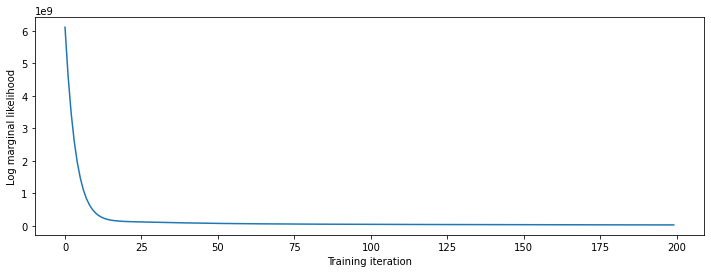

In [14]:
plot_loss_evolution(lls_)